<a href="https://colab.research.google.com/github/DysnomiaBorealis/SMS_SPAM_ML_MODEL/blob/main/SMS_SPAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install -q pandas numpy scikit-learn torch # Use torch backend for easier saving later
!pip install -q datasets transformers[torch] accelerate matplotlib seaborn # Install torch extras for transformers
!pip install -q evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 1.9 MB/s eta 0:00:00


In [7]:
import pandas as pd
import numpy as np
import torch
import evaluate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
CSV_PATH = 'indo_spam.csv' # <--- PUT YOUR CSV FILENAME HERE
MODEL_NAME = "cahya/bert-base-indonesian-522M" # Or "indobenchmark/indobert-base-p1" - Good Indonesian BERT models
# MODEL_NAME = "bert-base-multilingual-cased" # Alternative if Indonesian models fail, but less specific
TEST_SIZE = 0.2 # 20% for validation/testing
RANDOM_STATE = 42
OUTPUT_DIR = "./sms_spam_model_indonesian"
NUM_EPOCHS = 3 # Adjust as needed based on validation performance
BATCH_SIZE = 16 # Adjust based on your GPU memory

# --- Load Data ---
try:
    df = pd.read_csv(CSV_PATH)
    print("Dataset loaded successfully.")
    print("Columns:", df.columns)
    print("First 5 rows:\n", df.head())
except FileNotFoundError:
    print(f"Error: Could not find the dataset file at {CSV_PATH}")
    # Exit or handle error appropriately
    exit()
except Exception as e:
    print(f"Error loading dataset: {e}")
    exit()

# --- Basic Cleaning & Verification ---
# Ensure columns exist
if 'Kategori' not in df.columns or 'Pesan' not in df.columns:
     print("Error: CSV must contain 'Kategori' and 'Pesan' columns.")
     exit()

# Rename for clarity (optional, but good practice)
df = df.rename(columns={'Kategori': 'label', 'Pesan': 'text'})

# Handle missing values (if any)
df.dropna(subset=['text', 'label'], inplace=True)
df = df[df['text'].str.strip() != ''] # Remove rows with empty text after stripping whitespace

# Map labels to integers
label_map = {'ham': 0, 'Spam': 1} # IMPORTANT: Ensure 'Spam' is capitalized if it is in your CSV
df['label'] = df['label'].map(label_map)

# Check if mapping worked (handle potential case issues or different labels)
if df['label'].isnull().any():
    print("Error: Label mapping failed. Check label names in CSV ('ham', 'Spam') and capitalization.")
    print("Unique labels found:", df['label'].unique()) # Show original labels before mapping attempt if needed
    # Find original labels if mapping failed (helps debugging)
    df_original = pd.read_csv(CSV_PATH)
    print("Original unique labels:", df_original['Kategori'].unique())
    exit()

print("\nDataset after cleaning and mapping:")
print(df.head())
print("\nLabel distribution:")
print(df['label'].value_counts())

# Check for class imbalance
label_counts = df['label'].value_counts()
if abs(label_counts.get(0, 0) - label_counts.get(1, 0)) / len(df) > 0.4: # Example threshold
    print("\nWarning: Potential class imbalance detected. Consider techniques like weighting or resampling if performance suffers.")

# --- Split Data ---
train_df, test_df = train_test_split(df, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=df['label'])

print(f"\nTraining set size: {len(train_df)}")
print(f"Testing set size: {len(test_df)}")

# --- Convert to Hugging Face Dataset ---
train_dataset = Dataset.from_pandas(train_df[['text', 'label']].reset_index(drop=True))
test_dataset = Dataset.from_pandas(test_df[['text', 'label']].reset_index(drop=True))

dataset_dict = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

print("\nDatasetDict created:")
print(dataset_dict)

Dataset loaded successfully.
Columns: Index(['Kategori', 'Pesan'], dtype='object')
First 5 rows:
   Kategori                                              Pesan
0     Spam  (Bank Granit menerbitkan Strong-Buy) PILIHAN E...
1      ham  (Saya harus menambahkan bahwa saya tidak terla...
2      ham  (Yang mengatakan, bisakah Anda mengirim sms ke...
3     Spam  * GRATIS * POLIFONIK RINGTONE Teks SUPER ke 87...
4     Spam  **PESAN GRATIS**Terima kasih telah menggunakan...

Dataset after cleaning and mapping:
   label                                               text
0      1  (Bank Granit menerbitkan Strong-Buy) PILIHAN E...
1      0  (Saya harus menambahkan bahwa saya tidak terla...
2      0  (Yang mengatakan, bisakah Anda mengirim sms ke...
3      1  * GRATIS * POLIFONIK RINGTONE Teks SUPER ke 87...
4      1  **PESAN GRATIS**Terima kasih telah menggunakan...

Label distribution:
label
0    1302
1     743
Name: count, dtype: int64

Training set size: 1636
Testing set size: 409

DatasetDict 

In [9]:
# --- Load Tokenizer ---
# Use the tokenizer associated with the chosen Indonesian BERT model
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    print(f"\nTokenizer '{MODEL_NAME}' loaded.")
except Exception as e:
    print(f"Error loading tokenizer '{MODEL_NAME}': {e}")
    print("Ensure the model name is correct and you have an internet connection.")
    exit()

# --- Tokenization Function ---
def tokenize_function(examples):
    # padding='max_length' ensures all sequences have the same length.
    # truncation=True ensures sequences longer than the model's max length are cut.
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# --- Apply Tokenization ---
tokenized_datasets = dataset_dict.map(tokenize_function, batched=True)

print("\nDatasets after tokenization:")
print(tokenized_datasets)

# Remove the original text column as it's no longer needed for the model
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
# Rename label column to 'labels' as expected by the Trainer
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
# Set format to PyTorch tensors
tokenized_datasets.set_format("torch")

print("\nFinal tokenized datasets structure:")
print(tokenized_datasets['train'][0]) # Show an example

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/468 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/230k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]


Tokenizer 'cahya/bert-base-indonesian-522M' loaded.


Map:   0%|          | 0/1636 [00:00<?, ? examples/s]

Asking to pad to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no padding.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/409 [00:00<?, ? examples/s]


Datasets after tokenization:
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1636
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 409
    })
})

Final tokenized datasets structure:
{'labels': tensor(1), 'input_ids': tensor([    3,  2727,  1022,  3239, 19871,    14,  4878,  1583,  1555,  5892,
        24604,    23,    60,  1657,    52,  1023,    32,  1695,  1793,  1542,
         2871,  2219,  3397,    32,    20,    12,  1653,  2223, 23549,    15,
           21,    12,  1653,  7483,    15,    22,    12,  1653, 25225,    17,
        15029,    20,    15,    21,  1657,    22,  1519,  8553,  1065, 29290,
           17,  4523,  3617,  1029,    14,  4009,  1765,  1006,     1]), 'token_type_ids': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [11]:
# --- Load Model ---
try:
    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
    print(f"\nModel '{MODEL_NAME}' for sequence classification loaded.")
except Exception as e:
    print(f"Error loading model '{MODEL_NAME}': {e}")
    exit()

# --- Define Metrics ---
accuracy_metric = evaluate.load("accuracy") # NEW WAY
f1_metric = evaluate.load("f1")             # NEW WAY
precision_metric = evaluate.load("precision") # NEW WAY
recall_metric = evaluate.load("recall")       # NEW WAY

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    # Use the new metric objects loaded above
    accuracy = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels, average="binary")
    precision = precision_metric.compute(predictions=predictions, references=labels, average="binary")
    recall = recall_metric.compute(predictions=predictions, references=labels, average="binary")
    return {
        "accuracy": accuracy["accuracy"],
        "f1": f1["f1"],
        "precision": precision["precision"],
        "recall": recall["recall"],
    }


# --- Training Arguments ---
training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    num_train_epochs=NUM_EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500, # Number of steps for linear warmup
    weight_decay=0.01, # Regularization
    logging_dir='./logs',
    logging_steps=100, # Log metrics every 100 steps
    evaluation_strategy="epoch", # Evaluate at the end of each epoch
    save_strategy="epoch", # Save checkpoint at the end of each epoch
    load_best_model_at_end=True, # Load the best checkpoint when training finishes
    metric_for_best_model="f1", # Use F1 score to determine the best model (good for potentially imbalanced datasets)
    greater_is_better=True,
    # push_to_hub=False, # Set to True if you want to upload to Hugging Face Hub
    report_to="none",2 55
)

# --- Initialize Trainer ---
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"], # Using test set as validation here
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# --- Train ---
print("\nStarting training...")
train_result = trainer.train()
print("Training finished.")

# --- Save Training Stats ---
metrics = train_result.metrics
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)

# --- Save Model and Tokenizer ---
trainer.save_model(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)
print(f"\nModel and tokenizer saved to {OUTPUT_DIR}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cahya/bert-base-indonesian-522M and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model 'cahya/bert-base-indonesian-522M' for sequence classification loaded.


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-11-3aef5d388d34>:51: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



Starting training...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.320400,0.104671,0.973105,0.961938,0.992857,0.932886
2,0.103400,0.067099,0.982885,0.976431,0.979730,0.973154
3,0.055500,0.075728,0.980440,0.972789,0.986207,0.959732


Training finished.
***** train metrics *****
  epoch                    =        3.0
  total_flos               =   145244GF
  train_loss               =     0.1575
  train_runtime            = 1:03:37.96
  train_samples_per_second =      1.286
  train_steps_per_second   =      0.081

Model and tokenizer saved to ./sms_spam_model_indonesian



Evaluating on the test set...



Evaluation Results:
{'eval_loss': 0.06709899008274078, 'eval_accuracy': 0.9828850855745721, 'eval_f1': 0.9764309764309764, 'eval_precision': 0.9797297297297297, 'eval_recall': 0.9731543624161074, 'eval_runtime': 76.116, 'eval_samples_per_second': 5.373, 'eval_steps_per_second': 0.342, 'epoch': 3.0}
***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.9829
  eval_f1                 =     0.9764
  eval_loss               =     0.0671
  eval_precision          =     0.9797
  eval_recall             =     0.9732
  eval_runtime            = 0:01:16.11
  eval_samples_per_second =      5.373
  eval_steps_per_second   =      0.342

Generating detailed report and confusion matrix...

Classification Report:
              precision    recall  f1-score   support

     ham (0)       0.98      0.99      0.99       260
    Spam (1)       0.98      0.97      0.98       149

    accuracy                           0.98       409
   macro avg       0.98      

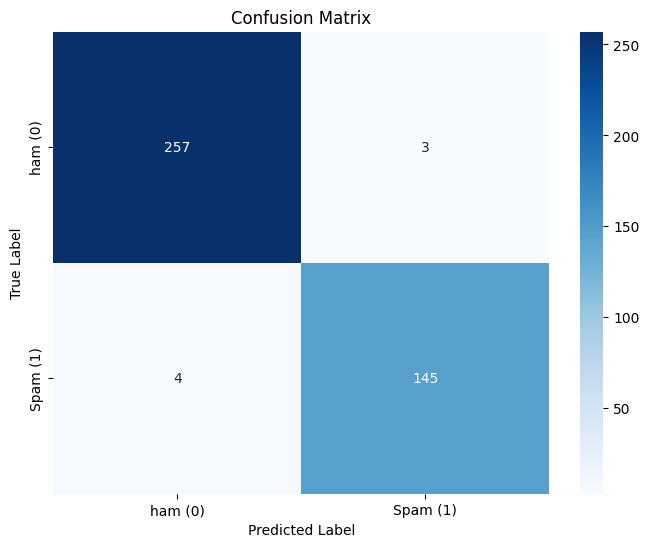

In [12]:
# --- Evaluate on Test Set ---
print("\nEvaluating on the test set...")
eval_results = trainer.evaluate(eval_dataset=tokenized_datasets["test"])
print("\nEvaluation Results:")
print(eval_results)
trainer.log_metrics("eval", eval_results)
trainer.save_metrics("eval", eval_results)

# --- Detailed Classification Report and Confusion Matrix ---
print("\nGenerating detailed report and confusion matrix...")
# Get predictions
predictions_output = trainer.predict(tokenized_datasets["test"])
y_pred = np.argmax(predictions_output.predictions, axis=-1)
y_true = tokenized_datasets["test"]["labels"].numpy() # Get true labels as numpy array

# Classification Report
print("\nClassification Report:")
target_names = ['ham (0)', 'Spam (1)']
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Plot Confusion Matrix (Optional, but nice)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()